In [1]:
import os
import pandas as pd
import numpy as np
import pickle
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from scipy.stats import f_oneway, chi2_contingency, kruskal
from sklearn.preprocessing import OneHotEncoder
import umap
import random
from tqdm import tqdm
from sklearn.manifold import trustworthiness
from sklearn.metrics import silhouette_score
from matplotlib.colors import ListedColormap
import warnings

In [2]:

df_train = pd.read_csv('Processed_Datasets/multiLCA_clustered.csv')


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9307 entries, 0 to 9306
Data columns (total 41 columns):
 #   Column                                                              Non-Null Count  Dtype  
---  ------                                                              --------------  -----  
 0   WasBreastfed.1                                                      9307 non-null   int64  
 1   HealthFacilityDelivery.1                                            9307 non-null   int64  
 2   SkilledDeliveryCareProvider.1                                       9307 non-null   int64  
 3   AntenatalCare.4...1                                                 9307 non-null   int64  
 4   NeonatalTetanusProtection.2...1                                     9307 non-null   int64  
 5   IronPillsDuringPregnancy.1                                          9307 non-null   int64  
 6   BabyPostnatalCheck.1                                                9307 non-null   int64  
 7   MaternalPostpar

In [4]:

cluster_sizes = df_train[df_train['Cluster_Labels'] != -1]['Cluster_Labels'].value_counts().sort_values(ascending=False)

cluster_names = ['First', 
                 'Second', 
                 'Third']

cluster_mapping = {label: name for label, name in zip(cluster_sizes.index, cluster_names)}

df_train['Segment'] = df_train['Cluster_Labels'].map(cluster_mapping)
df_train['Segment'] = df_train['Segment'].astype('category')
df_train['Segment'] = df_train['Segment'].cat.reorder_categories(cluster_names)

cluster_counts = df_train['Segment'].value_counts()
cluster_counts

Segment
First     5682
Second    1857
Third     1768
Name: count, dtype: int64

In [5]:

df_new1 = df_train.copy()
df_new = df_new1[['MetNeedFamilyPlanning.1','PreceedingBirthInterval.33...1', 'AntenatalCare.4...1', 'NeonatalTetanusProtection.2...1',
                  'IronPillsDuringPregnancy.1','HealthFacilityDelivery.1', 'SkilledDeliveryCareProvider.1', 
                  'BabyPostnatalCheck.1', 'MaternalPostpartumHealthCheck.1', 'WasBreastfed.1',
                  'ProtectedDrinkingWaterSource.1', 'ImprovedToiletFacility.1', 'CleanCookingFuel.1',
                  'NonTobaccoSmoker.1', 'DecisionMaking_Participation.1', 'OfAgeMarriage.1', 'Segment', 
                  'Cluster_Labels']]
df_new.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9307 entries, 0 to 9306
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   MetNeedFamilyPlanning.1          9307 non-null   int64   
 1   PreceedingBirthInterval.33...1   9307 non-null   int64   
 2   AntenatalCare.4...1              9307 non-null   int64   
 3   NeonatalTetanusProtection.2...1  9307 non-null   int64   
 4   IronPillsDuringPregnancy.1       9307 non-null   int64   
 5   HealthFacilityDelivery.1         9307 non-null   int64   
 6   SkilledDeliveryCareProvider.1    9307 non-null   int64   
 7   BabyPostnatalCheck.1             9307 non-null   int64   
 8   MaternalPostpartumHealthCheck.1  9307 non-null   int64   
 9   WasBreastfed.1                   9307 non-null   int64   
 10  ProtectedDrinkingWaterSource.1   9307 non-null   int64   
 11  ImprovedToiletFacility.1         9307 non-null   int64   
 12  CleanC

In [6]:
# cluster interpretation

categorical = df_new.select_dtypes(include='int')

features_to_plot = []
features_to_drop = []

def create_contingency_table(df, feature):
    contingency_table = pd.crosstab(df[feature], df['Segment'])
    return contingency_table

for feature in df_new.columns:
    if feature not in ['Segment', 'Cluster_Labels', 'country']:
        if feature in categorical.columns:
            contingency_table = create_contingency_table(df_new, feature)
            chi2, p_value, dof, expected = chi2_contingency(contingency_table)
        else:
            segments = df_new['Segment'].unique()
            groups = [df_new[df_new['Segment'] == segment][feature] for segment in segments]
            stat, p_value = kruskal(*groups)
        
        print(f"{feature}: p-value = {p_value}")        
        if p_value < 0.05/16:
            features_to_plot.append(feature)
        else:
            features_to_drop.append(feature)
print(len(features_to_plot))
print("Features to plot:", features_to_plot)
print("Features to drop:", features_to_drop)

df_new = df_new.drop(features_to_drop, axis=1)


MetNeedFamilyPlanning.1: p-value = 1.9676100429141887e-63
PreceedingBirthInterval.33...1: p-value = 8.40096245185427e-19
AntenatalCare.4...1: p-value = 0.0
NeonatalTetanusProtection.2...1: p-value = 0.0
IronPillsDuringPregnancy.1: p-value = 0.0
HealthFacilityDelivery.1: p-value = 0.0
SkilledDeliveryCareProvider.1: p-value = 0.0
BabyPostnatalCheck.1: p-value = 2.944339443269311e-66
MaternalPostpartumHealthCheck.1: p-value = 7.752841451945443e-87
WasBreastfed.1: p-value = 2.0934871081614183e-25
ProtectedDrinkingWaterSource.1: p-value = 8.955082932422914e-137
ImprovedToiletFacility.1: p-value = 2.4640450969859854e-151
CleanCookingFuel.1: p-value = 8.633727837221458e-60
NonTobaccoSmoker.1: p-value = 0.39818139603553276
DecisionMaking_Participation.1: p-value = 3.766760035394209e-20
OfAgeMarriage.1: p-value = 1.6022712583769001e-47
15
Features to plot: ['MetNeedFamilyPlanning.1', 'PreceedingBirthInterval.33...1', 'AntenatalCare.4...1', 'NeonatalTetanusProtection.2...1', 'IronPillsDuringPreg

In [7]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9307 entries, 0 to 9306
Data columns (total 17 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   MetNeedFamilyPlanning.1          9307 non-null   int64   
 1   PreceedingBirthInterval.33...1   9307 non-null   int64   
 2   AntenatalCare.4...1              9307 non-null   int64   
 3   NeonatalTetanusProtection.2...1  9307 non-null   int64   
 4   IronPillsDuringPregnancy.1       9307 non-null   int64   
 5   HealthFacilityDelivery.1         9307 non-null   int64   
 6   SkilledDeliveryCareProvider.1    9307 non-null   int64   
 7   BabyPostnatalCheck.1             9307 non-null   int64   
 8   MaternalPostpartumHealthCheck.1  9307 non-null   int64   
 9   WasBreastfed.1                   9307 non-null   int64   
 10  ProtectedDrinkingWaterSource.1   9307 non-null   int64   
 11  ImprovedToiletFacility.1         9307 non-null   int64   
 12  CleanC

In [8]:
column_mapping = {
    'MetNeedFamilyPlanning.1_1': 'Met Need for family planning',
    'PreceedingBirthInterval.33...1_1': 'Preceeding Birth Interval(33+ months)',
    'AntenatalCare.4...1_1': 'Antenatal Care(4+ visits)',
    'NeonatalTetanusProtection.2...1_1': 'Neonatal Tetanus Protection(2+ shots)',
    'IronPillsDuringPregnancy.1_1': 'Iron Pills During Pregnancy',
    'HealthFacilityDelivery.1_1': 'Health Facility Delivery',
    'SkilledDeliveryCareProvider.1_1': 'Skilled Delivery Care Provider',
    'BabyPostnatalCheck.1_1': 'Baby Postnatal Check',
    'MaternalPostpartumHealthCheck.1_1': 'Maternal Postpartum Health Check',
    'WasBreastfed.1_1': 'Was Breastfed',
    'ProtectedDrinkingWaterSource.1_1': 'Protected Drinking Water Source',
    'ImprovedToiletFacility.1_1': 'Improved Toilet Facility',
    'CleanCookingFuel.1_1': 'Clean Cooking Fuel',
    'DecisionMaking_Participation.1_1': 'Decision Making Participation',
    'OfAgeMarriage.1_1': 'Of Age Marriage',
}

In [9]:
### center and scale categorical features
categorical_columns = (df_new.select_dtypes(include=['int']).drop(['Cluster_Labels'], axis=1)).columns
encoder = OneHotEncoder(drop='if_binary', sparse_output=False)
df_dummies = pd.DataFrame(encoder.fit_transform(df_new[categorical_columns]), columns = encoder.get_feature_names_out(categorical_columns))
df_dummies = df_dummies.rename(columns=column_mapping)
df_dummies_scaled = pd.DataFrame(StandardScaler().fit_transform(df_dummies), columns=df_dummies.columns)

df_new = df_new.drop(categorical_columns, axis=1)
df_new = pd.concat([df_new, df_dummies_scaled], axis=1)

### get the means of features across all segments
df_new_columns = [col for col in df_new.columns if col not in ['Segment', 'country']]
aggregation_dict = {**{col: 'mean' for col in df_new_columns}}
aggregation_dict['Cluster_Labels'] = 'count'
segment_summary = df_new.groupby('Segment', observed=True).agg(aggregation_dict)

segment_summary.to_csv("Radar Plots/Three_Clusters_MLCA.csv", index=False)
segment_summary

,Cluster_Labels,Met Need for family planning,Preceeding Birth Interval(33+ months),Antenatal Care(4+ visits),Neonatal Tetanus Protection(2+ shots),Iron Pills During Pregnancy,Health Facility Delivery,Skilled Delivery Care Provider,Baby Postnatal Check,Maternal Postpartum Health Check,Was Breastfed,Protected Drinking Water Source,Improved Toilet Facility,Clean Cooking Fuel,Decision Making Participation,Of Age Marriage
Segment,,,,,,,,,,,,,,,,
First,5682,0.124826,0.060142,0.271197,0.177010,0.284685,0.778879,0.683267,0.025717,-0.024819,-0.088116,0.189305,0.205725,0.132413,0.055267,0.118325
Second,1857,-0.068602,-0.004803,0.124442,0.300844,0.375758,-1.221886,-0.980344,0.236685,0.357950,0.128098,-0.131668,-0.181028,-0.142279,0.021956,-0.131102
Third,1768,-0.329110,-0.188238,-1.002281,-0.884863,-1.309593,-1.219769,-1.166191,-0.331249,-0.296205,0.148641,-0.470094,-0.471018,-0.276107,-0.200678,-0.242571


In [10]:
df_dummies = df_dummies.rename(columns=column_mapping)


### Plotting cluster profiles

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


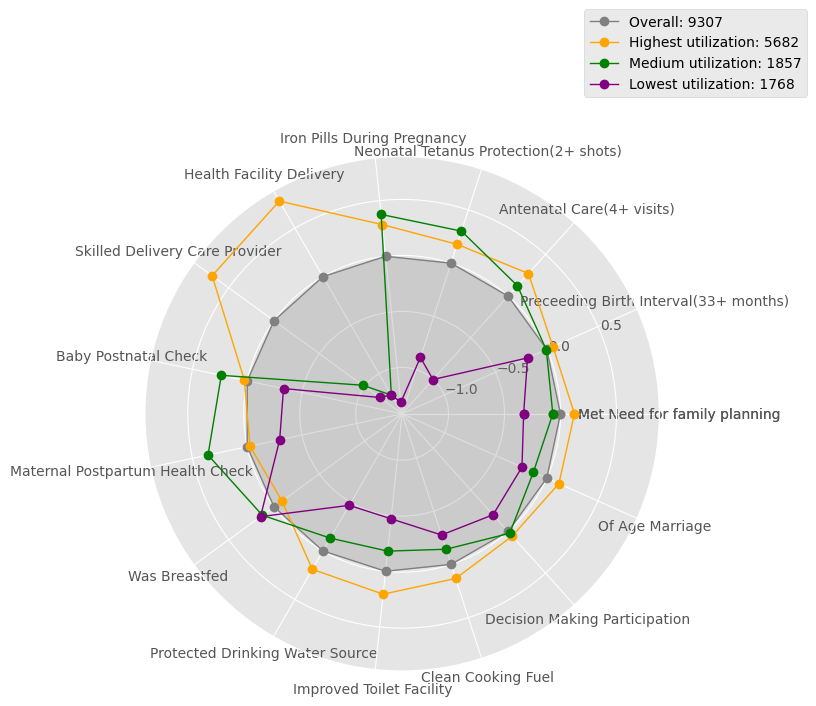

In [11]:
plt.style.use('ggplot')

## data for visualization
subjects = (segment_summary.drop(columns = "Cluster_Labels", axis = 1).columns).to_list()
overall = np.zeros(len(subjects)).tolist()
First = (segment_summary.loc['First', subjects]).to_list()
Second = (segment_summary.loc['Second', subjects]).to_list()
Third = (segment_summary.loc['Third', subjects]).to_list()

## Obtain angles
angles=np.linspace(0,2*np.pi,len(subjects), endpoint=False)

## completing the full circle
angles=np.concatenate((angles,[angles[0]]))
subjects.append(subjects[0])
overall.append(overall[0])
First.append(First[0])
Second.append(Second[0])
Third.append(Third[0])


## Plotting
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(111, polar=True)

#Overall Plot
ax.plot(angles, overall, 'o-', color='grey', linewidth=1, label=f"{'Overall'}: {segment_summary['Cluster_Labels'].sum()}")
ax.fill(angles, overall, alpha=0.25, color='grey')

#First Plot
ax.plot(angles, First, 'o-', color='orange', linewidth=1, label=f"{'Highest utilization'}: {segment_summary.loc['First','Cluster_Labels']}")

# Second Plot
ax.plot(angles, Second, 'o-', color='green', linewidth=1, label=f"{'Medium utilization'}: {segment_summary.loc['Second','Cluster_Labels']}")

# Third Plot
ax.plot(angles, Third, 'o-', color='purple', linewidth=1, label=f"{'Lowest utilization'}: {segment_summary.loc['Third','Cluster_Labels']}")


ax.set_thetagrids(angles * 180/np.pi, subjects)
plt.grid(True)
plt.tight_layout()
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.3))
plt.savefig('Radar Plots/Three_Clusters_MLCA.tiff', bbox_inches='tight', dpi=600)
plt.savefig('Radar Plots/Three_Clusters_MLCA.png', bbox_inches='tight', dpi=600)
plt.savefig('Radar Plots/Three_Clusters_MLCA.eps', format='eps', bbox_inches='tight')
plt.show()

### Plotting country assignments and U5MR

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


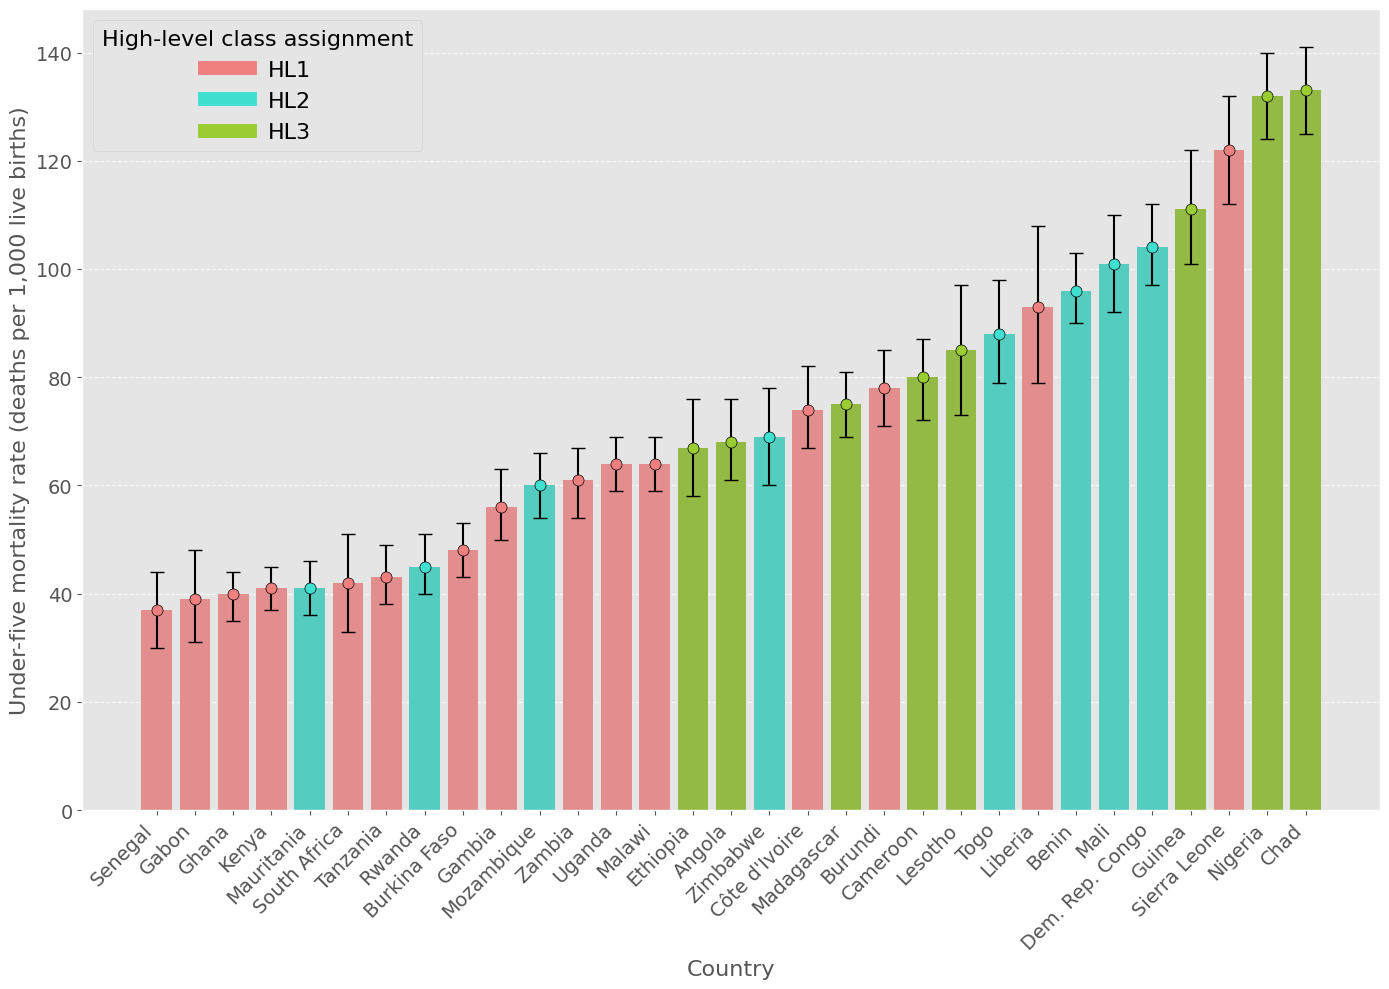

In [12]:

data = {
    "Country": ["Angola", "Burkina Faso", "Benin", "Burundi", "Dem. Rep. Congo", "Côte d'Ivoire", 
                "Cameroon", "Ethiopia", "Gabon", "Ghana", "Gambia", "Guinea", "Kenya", "Liberia", 
                "Lesotho", "Madagascar", "Mali", "Mauritania", "Malawi", "Mozambique", "Nigeria", 
                "Rwanda", "Sierra Leone", "Senegal", "Chad", "Togo", "Tanzania", "Uganda", 
                "South Africa", "Zambia", "Zimbabwe"],
    "Code": ["AO", "BF", "BJ", "BU", "CD", "CI", "CM", "ET", "GA", "GH", "GM", "GN", "KE", "LB", 
             "LS", "MD", "ML", "MR", "MW", "MZ", "NG", "RW", "SL", "SN", "TD", "TG", "TZ", "UG", 
             "ZA", "ZM", "ZW"],
    "MortalityRate": [68, 48, 96, 78, 104, 74, 80, 67, 39, 40, 56, 111, 41, 93, 85, 75, 101, 41, 
                      64, 60, 132, 45, 122, 37, 133, 88, 43, 64, 42, 61, 69],
    "LowerBound": [61, 43, 90, 71, 97, 67, 72, 58, 31, 35, 50, 101, 37, 79, 73, 69, 92, 36, 59, 
                  54, 124, 40, 112, 30, 125, 79, 38, 59, 33, 54, 60],
    "UpperBound": [76, 53, 103, 85, 112, 82, 87, 76, 48, 44, 63, 122, 45, 108, 97, 81, 110, 46, 
                  69, 66, 140, 51, 132, 44, 141, 98, 49, 69, 51, 67, 78],
    "HL1": [0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0],
    "HL2": [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
    "HL3": [1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
}

df = pd.DataFrame(data)
df['Class'] = np.where(df['HL1'] == 1, 'HL1', np.where(df['HL2'] == 1, 'HL2', 'HL3'))

df = df.sort_values('MortalityRate')
df.to_csv("Country Plots/Three_Clusters_MLCA.csv", index=False)


# Plotting
plt.figure(figsize=(14, 10))
palette = {'HL1': 'lightcoral', 'HL2': 'turquoise', 'HL3': 'yellowgreen'}
ax = sns.barplot(x='Country', y='MortalityRate', data=df, hue='Class', palette=palette, dodge=False)

sns.stripplot(x='Country', y='MortalityRate', data=df, hue='Class', palette=palette, dodge=False, marker='o', size=8, edgecolor='black', linewidth=0.5)

for i, row in enumerate(df.itertuples()):
    country_index = df['Country'].tolist().index(row.Country)
    ax.errorbar(
        x=country_index,
        y=row.MortalityRate,
        yerr=[[row.MortalityRate - row.LowerBound], [row.UpperBound - row.MortalityRate]],
        fmt='none',
        color='black',
        capsize=5
    )

ax.grid(axis='y', linestyle='--', alpha=0.7)

ax.tick_params(axis='x', labelsize=14) 
ax.tick_params(axis='y', labelsize=14) 

# Customize the plot
plt.ylabel('Under-five mortality rate (deaths per 1,000 live births)', fontsize=16)
plt.xlabel('Country', fontsize=16)

plt.xticks(rotation=45, ha='right')

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='lightcoral', lw=10, label='HL1'),
    Line2D([0], [0], color='turquoise', lw=10, label='HL2'),
    Line2D([0], [0], color='yellowgreen', lw=10, label='HL3')
]
ax.legend(handles=legend_elements, title='High-level class assignment', loc='upper left', fontsize = 16, title_fontsize=16)

plt.tight_layout()
plt.savefig('Country Plots/Three_Clusters_MLCA.tiff', bbox_inches='tight', dpi=600)
plt.savefig('Country Plots/Three_Clusters_MLCA.png', bbox_inches='tight', dpi=600)
plt.savefig('Country Plots/Three_Clusters_MLCA.eps', format='eps', bbox_inches='tight')
plt.show()


### Plotting model selection plots

In [13]:
model_selection = pd.read_csv('Processed_Datasets/model_selection.csv')
model_selection

model_selection = model_selection.drop(columns=['model_selection.BIChigh', 'model_selection.ICL_BIChigh', 'V1'])

model_selection.columns = model_selection.columns.str.replace('model_selection.', '')
model_selection = model_selection.replace('-', pd.NA).apply(pd.to_numeric, errors='coerce')

melted_data = model_selection.melt(id_vars='iT', var_name='Criterion', value_name='Value')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


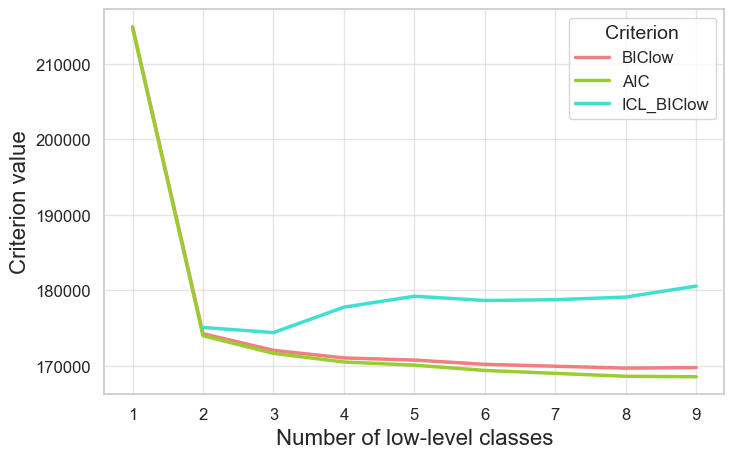

In [14]:
palette = {'BIClow': 'lightcoral', 'AIC': 'yellowgreen', 'ICL_BIClow':'turquoise'}

sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
plot = sns.lineplot(data=melted_data, x='iT', y='Value', hue='Criterion', palette=palette, linewidth=2.5)
plt.xlabel('Number of low-level classes', fontsize = 16)
plt.ylabel('Criterion value', fontsize = 16)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(title='Criterion', fontsize = 12, title_fontsize=14)
plt.grid(True, alpha = 0.5)
plt.savefig('Hyperparameter Plots/BIC_Low_MLCA.tiff', bbox_inches='tight', dpi=600)
plt.savefig('Hyperparameter Plots/BIC_Low_MLCA.png', bbox_inches='tight', dpi=600)
plt.savefig('Hyperparameter Plots/BIC_Low_MLCA.eps', format='eps', bbox_inches='tight')
plt.show()

In [15]:
model_selection1 = pd.read_csv('Processed_Datasets/model_selection1.csv')
model_selection1

# Replace non-numeric placeholders if there are any
model_selection1.replace('-', pd.NA, inplace=True)
model_selection1.columns = model_selection1.columns.str.replace('model_selection.', '')
model_selection1 = model_selection1.apply(pd.to_numeric, errors='coerce')

model_selection1_melted = model_selection1.melt(id_vars='iT', value_vars=['AIC', 'BIChigh', 'ICL_BIChigh'],
                                                var_name='Criterion', value_name='Value')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


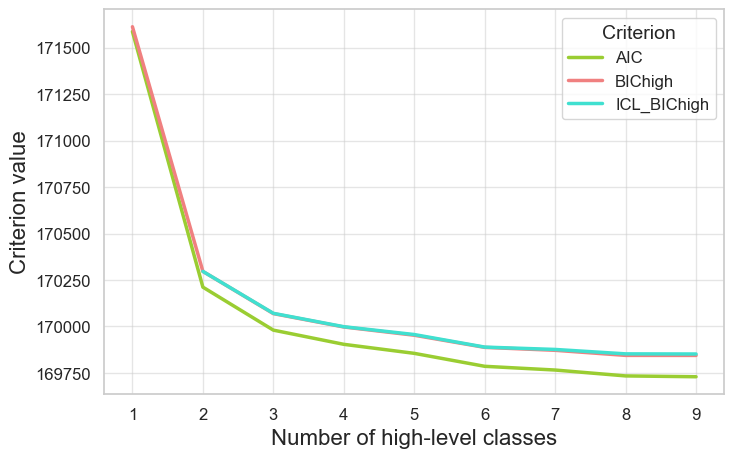

In [16]:
palette1 = {'BIChigh': 'lightcoral', 'AIC': 'yellowgreen', 'ICL_BIChigh':'turquoise'}

sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
plot = sns.lineplot(data=model_selection1_melted, x='iT', y='Value', hue='Criterion', palette=palette1, linewidth=2.5)
plt.xlabel('Number of high-level classes', fontsize = 16)
plt.ylabel('Criterion value', fontsize = 16)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(title='Criterion', fontsize = 12, title_fontsize=14)
plt.grid(True, alpha = 0.5)
plt.savefig('Hyperparameter Plots/BIC_High_MLCA.tiff', bbox_inches='tight', dpi=600)
plt.savefig('Hyperparameter Plots/BIC_High_MLCA.png', bbox_inches='tight', dpi=600)
plt.savefig('Hyperparameter Plots/BIC_High_MLCA.eps', format='eps', bbox_inches='tight')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


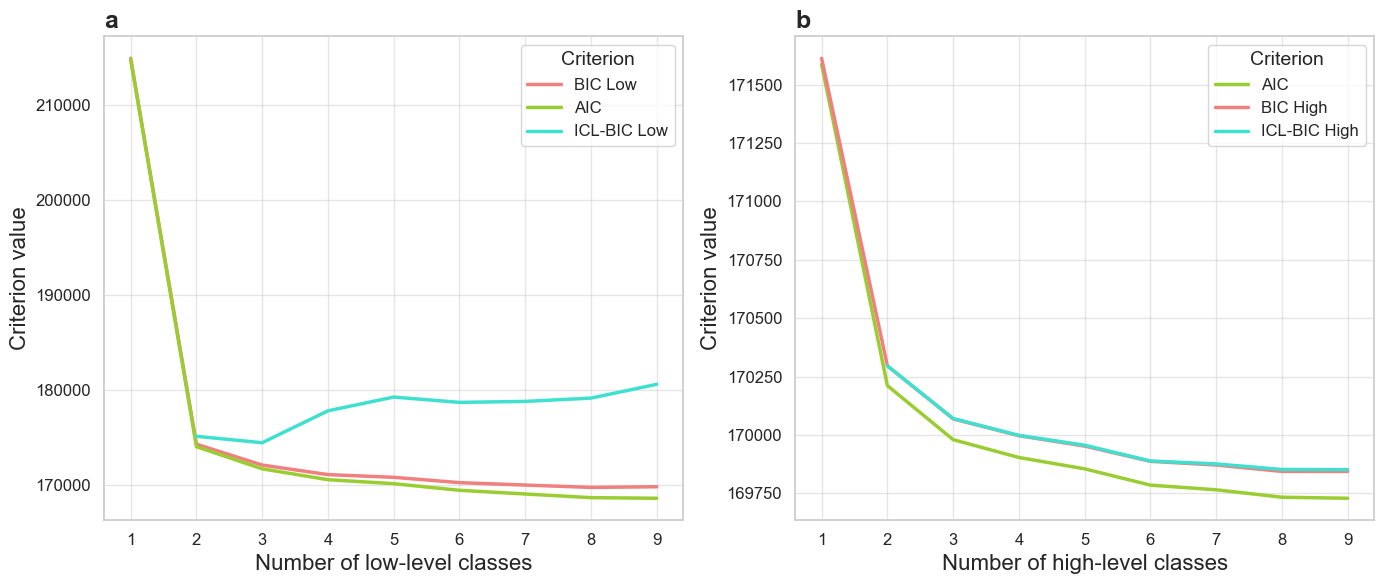

In [17]:
#### Using a single plot

sns.set(style="whitegrid")
palette_low = {'BIClow': 'lightcoral', 'AIC': 'yellowgreen', 'ICL_BIClow': 'turquoise'}
palette_high = {'BIChigh': 'lightcoral', 'AIC': 'yellowgreen', 'ICL_BIChigh': 'turquoise'}

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  

# Panel (a): Low-level classes
sns.lineplot(ax=axes[0], data=melted_data, x='iT', y='Value', hue='Criterion',
             palette=palette_low, linewidth=2.5)
axes[0].set_xlabel('Number of low-level classes', fontsize=16)
axes[0].set_ylabel('Criterion value', fontsize=16)
axes[0].tick_params(axis='both', which='major', labelsize=12)
axes[0].legend(title='Criterion', fontsize=12, title_fontsize=14)
axes[0].set_title('a', loc='left', fontsize=18, fontweight='bold')
axes[0].grid(True, alpha=0.5)

# Custom legend labels for panel (a)
handles, labels = axes[0].get_legend_handles_labels()
label_map = {'BIClow': 'BIC Low', 'AIC': 'AIC', 'ICL_BIClow': 'ICL-BIC Low'}
new_labels = [label_map.get(l, l) for l in labels]
axes[0].legend(handles=handles, labels=new_labels, title='Criterion', fontsize=12, title_fontsize=14)

# Panel (b): High-level classes
sns.lineplot(ax=axes[1], data=model_selection1_melted, x='iT', y='Value', hue='Criterion',
             palette=palette_high, linewidth=2.5)
axes[1].set_xlabel('Number of high-level classes', fontsize=16)
axes[1].set_ylabel('Criterion value', fontsize=16)
axes[1].tick_params(axis='both', which='major', labelsize=12)
axes[1].legend(title='Criterion', fontsize=12, title_fontsize=14)
axes[1].set_title('b', loc='left', fontsize=18, fontweight='bold')
axes[1].grid(True, alpha=0.5)

# Custom legend labels for panel (b)
handles, labels = axes[1].get_legend_handles_labels()
label_map = {'BIChigh': 'BIC High', 'AIC': 'AIC', 'ICL_BIChigh': 'ICL-BIC High'}
new_labels = [label_map.get(l, l) for l in labels]
axes[1].legend(handles=handles, labels=new_labels, title='Criterion', fontsize=12, title_fontsize=14)

# Layout and save
plt.tight_layout()
plt.savefig('Hyperparameter Plots/Combined_MLCA.tiff', bbox_inches='tight', dpi=600)
plt.savefig('Hyperparameter Plots/Combined_MLCA.png', bbox_inches='tight', dpi=600)
plt.savefig('Hyperparameter Plots/Combined_MLCA.eps', format='eps', bbox_inches='tight')
plt.show()
